#### Search for right weights (cont.)
Okay, we probably have an approximation of what the right weights for how teams get seeded for the tournament. We can use a random search algorithm with defined distributions to try to find the right weights.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import statsmodels.api as sms
import sklearn
import seaborn as sbn
import warnings

warnings.simplefilter("ignore")

Can we create a distribution that:
- Takes a distribution based on our findings from which models performed the best
- Make sure the joint weights sum to 1

In [3]:
# Generate consistent results
np.random.seed(42)
# Create initial weights DataFrame
weights = pd.DataFrame(np.matrix(np.random.multivariate_normal(mean=[
    0.375,
    0.325,
    0.2,
    0.05,
    0.05
], cov=np.matrix([[0.001125, 0, 0, 0, 0],
                  [0, 0.0025, 0, 0, 0],
                  [0, 0, 0.0016, 0, 0],
                  [0, 0, 0, 0.002025, 0],
                  [0, 0, 0, 0, 0.002025]]),
                             size=250000)), columns=[
    "wp_weight",
    "owp_weight",
    "dowp_weight",
    "oowp_weight",
    "doowp_weight"
])
# Any weights that are less than zero need to be zeroed out
weights[weights < 0] = 0
# See what the sums add up to
weights["sum"] = weights.sum(axis=1)
# View first few rows of the weights DataFrame
weights.head()

,wp_weight,owp_weight,dowp_weight,oowp_weight,doowp_weight,sum
0,0.367146,0.349836,0.260921,0.043778,0.079146,1.100827
1,0.393198,0.313293,0.181221,0.121065,0.084535,1.093311
2,0.317144,0.301829,0.123469,0.029042,0.060888,0.832373
3,0.327630,0.296886,0.163679,0.004423,0.064141,0.856758
4,0.356741,0.398282,0.143010,0.039840,0.053039,0.990912


Okay, the joint distributions do not spit out weights that add up to 1. Some are close, but we need to adjust the weights.

In [4]:
# We need to adjust the weights now
weights["wpw_adj"] = weights["wp_weight"] / weights["sum"]
weights["owpw_adj"] = weights["owp_weight"] / weights["sum"]
weights["dowpw_adj"] = weights["dowp_weight"] / weights["sum"]
weights["oowpw_adj"] = weights["oowp_weight"] / weights["sum"]
weights["doowpw_adj"] = weights["doowp_weight"] / weights["sum"]
# Save the new weights
weights_adj = weights[[
    "wpw_adj", "owpw_adj", "dowpw_adj", "oowpw_adj", "doowpw_adj"
]]
weights_adj["Error"] = [None] * len(weights_adj)
weights_adj["MAE"] = [None] * len(weights_adj)
weights_adj.head(10)

,wpw_adj,owpw_adj,dowpw_adj,oowpw_adj,doowpw_adj,Error,MAE
0,0.333519,0.317793,0.237023,0.039768,0.071897,None,None
1,0.359640,0.286554,0.165754,0.110732,0.077320,None,None
2,0.381013,0.362613,0.148334,0.034891,0.073150,None,None
3,0.382406,0.346522,0.191045,0.005162,0.074865,None,None
4,0.360013,0.401935,0.144322,0.040205,0.053525,None,None
5,0.389090,0.352153,0.187477,0.000000,0.071280,None,None
6,0.387873,0.284135,0.151927,0.128478,0.047587,None,None
7,0.447979,0.309871,0.172420,0.069731,0.000000,None,None
8,0.332799,0.370142,0.192224,0.059022,0.045813,None,None
9,0.334087,0.305680,0.226075,0.030960,0.103199,None,None


In [5]:
# Let's see if we can zero in on the weights
# 2024 WIAA Tournament Seeding data
wiaa24 = pd.read_excel("wiaa_model_inputs_2024_no_def_oos.xlsx")
wiaa24_so = wiaa24[wiaa24["Seed"].isnull() == False].reset_index(drop=True)
# Create a few empty columns with the predictions
wiaa24_so["Score"] = [None] * len(wiaa24_so)
wiaa24_so["Predicted_Seed"] = [None] * len(wiaa24_so)
wiaa24_so["Error"] = [None] * len(wiaa24_so)
wiaa24_so.head()

,Team,Division,Sectional,Seed,Year,w%,ow%,oow%,dow%,doow%,Score,Predicted_Seed,Error
0,Abbotsford,4.0,1B,5.0,2024.0,0.476190,0.516269,0.504607,0.356164,0.499301,None,None,None
1,Abundant Life Christian/St. Ambrose,4.0,4B,5.0,2024.0,0.761905,0.409639,0.504478,0.320261,0.502876,None,None,None
2,Adams-Friendship,3.0,1B,9.0,2024.0,0.173913,0.575937,0.482784,0.194030,0.516393,None,None,None
3,Albany/Monticello,5.0,4B,1.0,2024.0,0.869565,0.461538,0.510967,0.397129,0.514428,None,None,None
4,Algoma,4.0,2B,6.0,2024.0,0.545455,0.482180,0.491527,0.284615,0.505536,None,None,None


In [6]:
# Run through and calculate the DataFrame
for i in range(len(weights_adj)):
    # Calculate the statistic used for predictions
    for j in range(len(wiaa24_so)):
        # print("Weights combination: " + str(i) + ", Observation: " + str(j))
        # Calculate the predictions
        wiaa24_so.at[j, "Score"] = weights_adj.at[i, "wpw_adj"] * wiaa24_so.at[j, "w%"] +\
                                weights_adj.at[i, "owpw_adj"] * wiaa24_so.at[j, "ow%"] +\
                                weights_adj.at[i, "dowpw_adj"] * wiaa24_so.at[j, "dow%"] +\
                                weights_adj.at[i, "oowpw_adj"] * wiaa24_so.at[j, "oow%"] +\
                                weights_adj.at[i, "doowpw_adj"] * wiaa24_so.at[j, "doow%"]
    # Organize the DataFrame by Division, Sectional, and Prediction
    wiaa24_so = wiaa24_so.sort_values(by=[
        "Division",
        "Sectional",
        "Score"
    ]).reset_index(drop=True)
    # Calculate the seeds
    wiaa24_so["Predicted_Seed"] = wiaa24_so.groupby(["Division", "Sectional"]).cumcount(ascending=False) + 1
    wiaa24_so["Error"] = np.abs(wiaa24_so["Seed"] - wiaa24_so["Predicted_Seed"])
    # Calculate the total absolute error and average the data by average miss
    error = np.sum(wiaa24_so["Error"])
    mae = error / len(wiaa24_so["Error"])
    # Write the error and MAE to the dataframe
    weights_adj.at[i, "Error"] = error
    weights_adj.at[i, "MAE"] = mae
    # Check progress
    if i == 0:
        print("Random search for right weights - starting tests.")
    elif ((i+1) % 25000 == 0) and (i != 0) and ((i+1) != 250000):
        print(f"{i+1} weight models tested.")
    elif (i+1) == 250000:
        print("All weights tested.")
    else:
        continue

Random search for right weights - starting tests.
25000 weight models tested.
50000 weight models tested.
75000 weight models tested.
100000 weight models tested.
125000 weight models tested.
150000 weight models tested.
175000 weight models tested.
200000 weight models tested.
225000 weight models tested.
All weights tested.


In [7]:
quarter_avg = weights_adj[weights_adj["MAE"] < 0.25].sort_values(by=["MAE"], ascending=True).reset_index(drop=True)

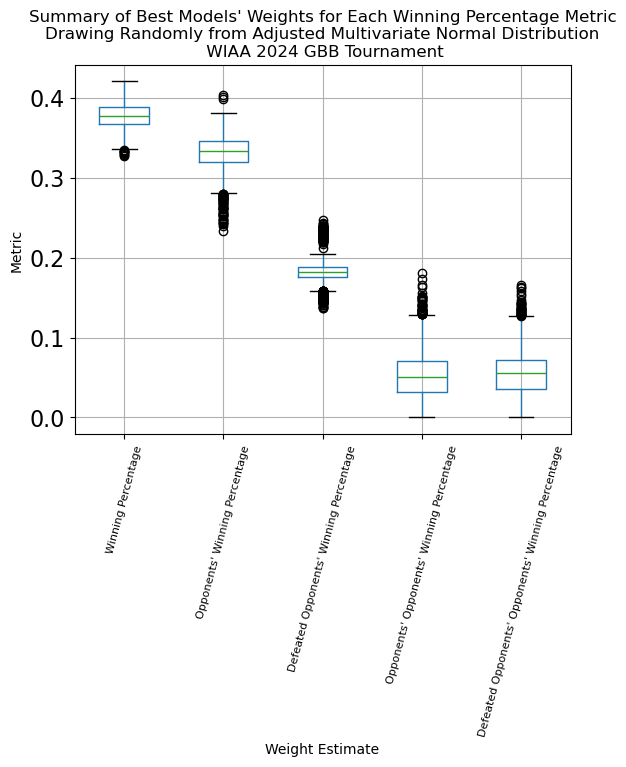

In [8]:
fig, ax = plt.subplots()
quarter_avg.boxplot(column=["wpw_adj", "owpw_adj", "dowpw_adj", "oowpw_adj", "doowpw_adj"], fontsize=16, rot=0, grid=True, figsize=(12,8))
ax.set_xlabel("Weight Estimate")
ax.set_ylabel("Metric")
ax.set_xticklabels([
    "Winning Percentage",
    "Opponents' Winning Percentage",
    "Defeated Opponents' Winning Percentage",
    "Opponents' Opponents' Winning Percentage",
    "Defeated Opponents' Opponents' Winning Percentage"
], rotation=75, fontdict={"size": 8})
ax.set_title("Summary of Best Models' Weights for Each Winning Percentage Metric\nDrawing Randomly from Adjusted Multivariate Normal Distribution\n WIAA 2024 GBB Tournament")
plt.show()

In [9]:
quarter_avg.describe()

,wpw_adj,owpw_adj,dowpw_adj,oowpw_adj,doowpw_adj
count,2610.000000,2610.000000,2610.000000,2610.000000,2610.000000
mean,0.378624,0.332344,0.181904,0.052733,0.054394
std,0.017115,0.021542,0.013424,0.031516,0.030303
min,0.326694,0.232763,0.137239,0.000000,0.000000
25%,0.367005,0.319706,0.176023,0.031814,0.035565
50%,0.376889,0.332986,0.182178,0.050925,0.055330
75%,0.388552,0.345795,0.187736,0.070311,0.072319
max,0.420217,0.402814,0.247281,0.180843,0.165095


In [10]:
quarter_avg

,wpw_adj,owpw_adj,dowpw_adj,oowpw_adj,doowpw_adj,Error,MAE
0,0.367618,0.316171,0.180918,0.064445,0.070848,108.0,0.235808
1,0.370527,0.322267,0.180876,0.062478,0.063852,108.0,0.235808
2,0.373084,0.325885,0.181571,0.062456,0.057004,108.0,0.235808
3,0.368874,0.320501,0.183246,0.047296,0.080084,110.0,0.240175
4,0.408436,0.340044,0.189476,0.039536,0.022507,110.0,0.240175
...,...,...,...,...,...,...,...
2605,0.365468,0.313088,0.239336,0.060443,0.021665,114.0,0.248908
2606,0.351474,0.285364,0.184591,0.083015,0.095556,114.0,0.248908
2607,0.365614,0.324037,0.184316,0.039710,0.086323,114.0,0.248908
2608,0.350280,0.304994,0.184063,0.065612,0.095051,114.0,0.248908


In [11]:
for j in range(len(wiaa24_so)):
    # Calculate the predictions
    wiaa24_so.at[j, "Score"] = quarter_avg.at[0, "wpw_adj"] * wiaa24_so.at[j, "w%"] +\
                               quarter_avg.at[0, "owpw_adj"] * wiaa24_so.at[j, "ow%"] +\
                               quarter_avg.at[0, "dowpw_adj"] * wiaa24_so.at[j, "dow%"] +\
                               quarter_avg.at[0, "oowpw_adj"] * wiaa24_so.at[j, "oow%"] +\
                               quarter_avg.at[0, "doowpw_adj"] * wiaa24_so.at[j, "doow%"]
# Organize the DataFrame by Division, Sectional, and Prediction
wiaa24_so = wiaa24_so.sort_values(by=[
    "Division",
    "Sectional",
    "Score"
]).reset_index(drop=True)
# Calculate the seeds
wiaa24_so["Predicted_Seed"] = wiaa24_so.groupby(["Division", "Sectional"]).cumcount(ascending=False) + 1
wiaa24_so["Error"] = np.abs(wiaa24_so["Seed"] - wiaa24_so["Predicted_Seed"])

In [12]:
# View D5 Sectional 2 seeding predictions
wiaa24_so[(wiaa24_so["Division"] == 5) & (wiaa24_so["Sectional"].str.contains("2"))].sort_values(by=["Sectional", "Seed"]).reset_index(drop=True)

,Team,Division,Sectional,Seed,Year,w%,ow%,oow%,dow%,doow%,Score,Predicted_Seed,Error
0,Pacelli,5.0,2A,1.0,2024.0,0.954545,0.447479,0.523083,0.433921,0.523734,0.641707,1,0.0
1,Pittsville,5.0,2A,2.0,2024.0,0.809524,0.462389,0.500701,0.391781,0.503701,0.582624,2,0.0
2,Greenwood,5.0,2A,3.0,2024.0,0.727273,0.512712,0.501685,0.421538,0.494725,0.573108,3,0.0
3,Athens,5.0,2A,4.0,2024.0,0.636364,0.549793,0.510818,0.370492,0.514476,0.544165,4,0.0
4,Loyal,5.0,2A,5.0,2024.0,0.650000,0.484018,0.518606,0.339161,0.520968,0.523675,5,0.0
5,Columbus Catholic,5.0,2A,6.0,2024.0,0.434783,0.566802,0.498340,0.341121,0.492731,0.46778,6,0.0
6,Edgar,5.0,2A,7.0,2024.0,0.454545,0.545833,0.502057,0.304147,0.504492,0.462798,7,0.0
7,Three Lakes/Phelps,5.0,2A,8.0,2024.0,0.400000,0.495261,0.501346,0.226994,0.495743,0.412133,8,0.0
8,Rib Lake,5.0,2A,9.0,2024.0,0.333333,0.480349,0.508821,0.259542,0.491504,0.388981,9,0.0
9,Newman Catholic,5.0,2A,10.0,2024.0,0.318182,0.493724,0.506964,0.264901,0.498385,0.388977,10,0.0


In [13]:
packerland = wiaa24_so[
    (wiaa24_so["Team"].str.contains("Green Bay N.E.W.")) | \
    (wiaa24_so["Team"] == "Gibraltar") | (wiaa24_so["Team"] == "Algoma") | \
    (wiaa24_so["Team"] == "Kewaunee") | (wiaa24_so["Team"] == "Oconto") | \
    (wiaa24_so["Team"] == "Peshtigo") | (wiaa24_so["Team"] == "Sevastopol") | \
    (wiaa24_so["Team"] == "Sturgeon Bay") | (wiaa24_so["Team"] == "Southern Door")
].sort_values(by=["Team"], ignore_index=True).reset_index(drop=True)
packerland

,Team,Division,Sectional,Seed,Year,w%,ow%,oow%,dow%,doow%,Score,Predicted_Seed,Error
0,Algoma,4.0,2B,6.0,2024.0,0.545455,0.482180,0.491527,0.284615,0.505536,0.471955,6,0.0
1,Gibraltar,5.0,2B,10.0,2024.0,0.409091,0.452991,0.486549,0.208556,0.489813,0.397401,10,0.0
2,Green Bay N.E.W. Lutheran/Providence Academy (...,5.0,2B,12.0,2024.0,0.272727,0.516807,0.487914,0.207692,0.496575,0.367859,13,1.0
3,Kewaunee,4.0,2B,1.0,2024.0,0.904762,0.497817,0.492880,0.469880,0.492880,0.641695,1,0.0
4,Oconto,4.0,2A,6.0,2024.0,0.681818,0.493671,0.486937,0.375415,0.503542,0.541708,6,0.0
5,Peshtigo,3.0,2A,9.0,2024.0,0.090909,0.583682,0.476707,0.477273,0.472222,0.368488,7,2.0
6,Sevastopol,5.0,2B,2.0,2024.0,0.857143,0.429515,0.512117,0.360825,0.512591,0.5855,2,0.0
7,Southern Door,4.0,2B,10.0,2024.0,0.363636,0.472574,0.481474,0.241176,0.495146,0.392835,10,0.0
8,Sturgeon Bay,3.0,2A,10.0,2024.0,0.200000,0.457666,0.477804,0.091954,0.526204,0.302933,10,0.0


In [14]:
pc = round(len(wiaa24_so[wiaa24_so["Error"] == 0]) / len(wiaa24_so) * 100., 2)
am = round(sum(wiaa24_so["Error"]) / sum(wiaa24_so["Error"] > 0.), 2)
print(f"Percentage of correctly seeded teams: {str(pc)}%")
print(f"Average miss size: {am}")

Percentage of correctly seeded teams: 79.69%
Average miss size: 1.16


In [15]:
wiaa24_so[((wiaa24_so["Predicted_Seed"] == 8) | (wiaa24_so["Predicted_Seed"] == 9)) & (wiaa24_so["Division"] == 5)]

,Team,Division,Sectional,Seed,Year,w%,ow%,oow%,dow%,doow%,Score,Predicted_Seed,Error
340,Frederic,5.0,1A,10.0,2024.0,0.272727,0.567511,0.492281,0.409449,0.469844,0.418779,9,1.0
341,Eau Claire Immanuel Lutheran,5.0,1A,7.0,2024.0,0.500000,0.507853,0.496646,0.313609,0.507155,0.469052,8,1.0
356,Lake Holcombe,5.0,1B,8.0,2024.0,0.454545,0.416136,0.465626,0.229665,0.456952,0.402601,9,1.0
357,Gilman,5.0,1B,9.0,2024.0,0.409091,0.471698,0.501599,0.211340,0.481152,0.404176,8,1.0
371,Rib Lake,5.0,2A,9.0,2024.0,0.333333,0.480349,0.508821,0.259542,0.491504,0.388981,9,0.0
372,Three Lakes/Phelps,5.0,2A,8.0,2024.0,0.400000,0.495261,0.501346,0.226994,0.495743,0.412133,8,0.0
387,Bowler,5.0,2B,9.0,2024.0,0.550000,0.423077,0.467719,0.245000,0.443689,0.441856,9,0.0
388,Niagara,5.0,2B,7.0,2024.0,0.500000,0.552916,0.493528,0.331522,0.505734,0.486239,8,1.0
402,Wonewoc-Center,5.0,3A,9.0,2024.0,0.450000,0.524027,0.493660,0.326425,0.500000,0.457404,9,0.0
403,Brookwood,5.0,3A,8.0,2024.0,0.565217,0.459350,0.488665,0.336996,0.496050,0.480622,8,0.0


When we predict 8 and 9 seeds, we need to check if they played each other. If teams played each other, then check if the 9 seed has a 100% record against the 8 seed. If that is the case, the seeds flip. There are ways to do this by defining a function to do this, but for now, we will hard code the seed flips.

In [16]:
# Predictions with flips
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Appleton North"] = 8
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Oshkosh West"] = 9
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Port Washington"] = 8
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Plymouth"] = 9
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Kewaskum"] = 8
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "North Fond du Lac"] = 9
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Lake Holcombe"] = 8
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Gilman"] = 9
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Kenosha Christian Life"] = 8 #wrong
wiaa24_so["Predicted_Seed"][wiaa24_so["Team"] == "Heritage Christian"] = 9 #wrong
# Update Error and MAE
wiaa24_so["Error"] = np.abs(wiaa24_so["Seed"] - wiaa24_so["Predicted_Seed"])

In [17]:
pc = round(len(wiaa24_so[wiaa24_so["Error"] == 0]) / len(wiaa24_so) * 100., 2)
am = round(sum(wiaa24_so["Error"]) / sum(wiaa24_so["Error"] > 0.), 2)
print(f"Percentage of correctly seeded teams - with 8v9 games flipped: {str(pc)}%")
print(f"Average miss size - with 8v9 games flipped: {am}")

Percentage of correctly seeded teams - with 8v9 games flipped: 81.44%
Average miss size - with 8v9 games flipped: 1.18


In [18]:
misses = wiaa24_so[wiaa24_so["Error"] != 0].reset_index(drop=True)
misses.head()

,Team,Division,Sectional,Seed,Year,w%,ow%,oow%,dow%,doow%,Score,Predicted_Seed,Error
0,Wausau West,1.0,1A,12.0,2024.0,0.428571,0.513978,0.509608,0.319797,0.500000,0.446178,13,1.0
1,Oshkosh North,1.0,1A,13.0,2024.0,0.363636,0.574786,0.533094,0.377358,0.516358,0.454619,12,1.0
2,Stevens Point,1.0,1A,5.0,2024.0,0.681818,0.470954,0.528058,0.435583,0.505771,0.548219,6,1.0
3,Superior,1.0,1A,6.0,2024.0,0.619048,0.538071,0.525766,0.511111,0.511546,0.56029,5,1.0
4,Neenah,1.0,1A,3.0,2024.0,0.826087,0.535714,0.560331,0.470024,0.553137,0.633397,4,1.0


In [19]:
misses.to_excel("misses.xlsx", index=False)